In [ ]:
!pip install gymnasium pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow keras plotly transformers torch shap catboost gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from xgboost import plot_importance
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import gymnasium as gym
from gymnasium import spaces
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')



In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

In [ ]:
food_security = pd.read_csv('/content/drive/MyDrive/datasets/Global Food Security Index 2022.csv')
food_demand = pd.read_csv('/content/drive/MyDrive/datasets/Food demand.csv')
nutrition = pd.read_excel('/content/drive/MyDrive/datasets/nutrition.xlsx')
logistics = pd.read_csv('/content/drive/MyDrive/datasets/dynamic_supply_chain_logistics_dataset.csv')
zero_hunger = pd.read_excel('/content/drive/MyDrive/datasets/Zero_Hunger.xlsx')


In [ ]:
food_security = food_security.drop(['Unnamed: 0', 'Rank'], axis=1)
food_security.columns = ['country', 'overall_score', 'affordability', 'availability', 'quality_safety', 'sustainability']
food_security['country'] = food_security['country'].str.strip()

In [ ]:
food_demand = food_demand.drop('id', axis=1)
food_demand['price_diff'] = food_demand['base_price'] - food_demand['checkout_price']
food_demand['discount_percentage'] = (food_demand['price_diff'] / food_demand['base_price']) * 100
food_demand['week_sin'] = np.sin(2 * np.pi * food_demand['week']/52)
food_demand['week_cos'] = np.cos(2 * np.pi * food_demand['week']/52)

In [ ]:
nutrition = nutrition.drop('Unnamed: 0', axis=1)
nutrition_columns_to_clean = nutrition.columns[3:]
for col in nutrition_columns_to_clean:
    nutrition[col] = pd.to_numeric(nutrition[col].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce')
nutrition = nutrition.dropna(thresh=nutrition.shape[1]-10)
numeric_cols = nutrition.select_dtypes(include=['float64', 'int64']).columns
nutrition[numeric_cols] = nutrition[numeric_cols].fillna(nutrition[numeric_cols].median())
nutrition['protein_per_calorie'] = nutrition['protein'].astype(float) / nutrition['calories']
nutrition['fiber_per_calorie'] = nutrition['fiber'].astype(float) / nutrition['calories']

In [ ]:
logistics['timestamp'] = pd.to_datetime(logistics['timestamp'])
logistics['hour'] = logistics['timestamp'].dt.hour
logistics['day_of_week'] = logistics['timestamp'].dt.dayofweek
logistics['month'] = logistics['timestamp'].dt.month
logistics['is_weekend'] = logistics['day_of_week'].isin([5,6]).astype(int)
logistics['efficiency_score'] = (1 - logistics['eta_variation_hours']/10) * (1 - logistics['traffic_congestion_level']/10) * (1 - logistics['loading_unloading_time']/5)
logistics['risk_score'] = logistics['route_risk_level'] * logistics['disruption_likelihood_score'] * logistics['delay_probability']

In [ ]:
zero_hunger = zero_hunger.rename(columns={'Prevalence of undernourishment (% of population)': 'undernourishment_percent'})
zero_hunger = zero_hunger.dropna(subset=['Code'])
zero_hunger['undernourishment_category'] = pd.cut(zero_hunger['undernourishment_percent'],
                                                 bins=[0,5,15,25,100],
                                                 labels=['low','moderate','high','very_high'])

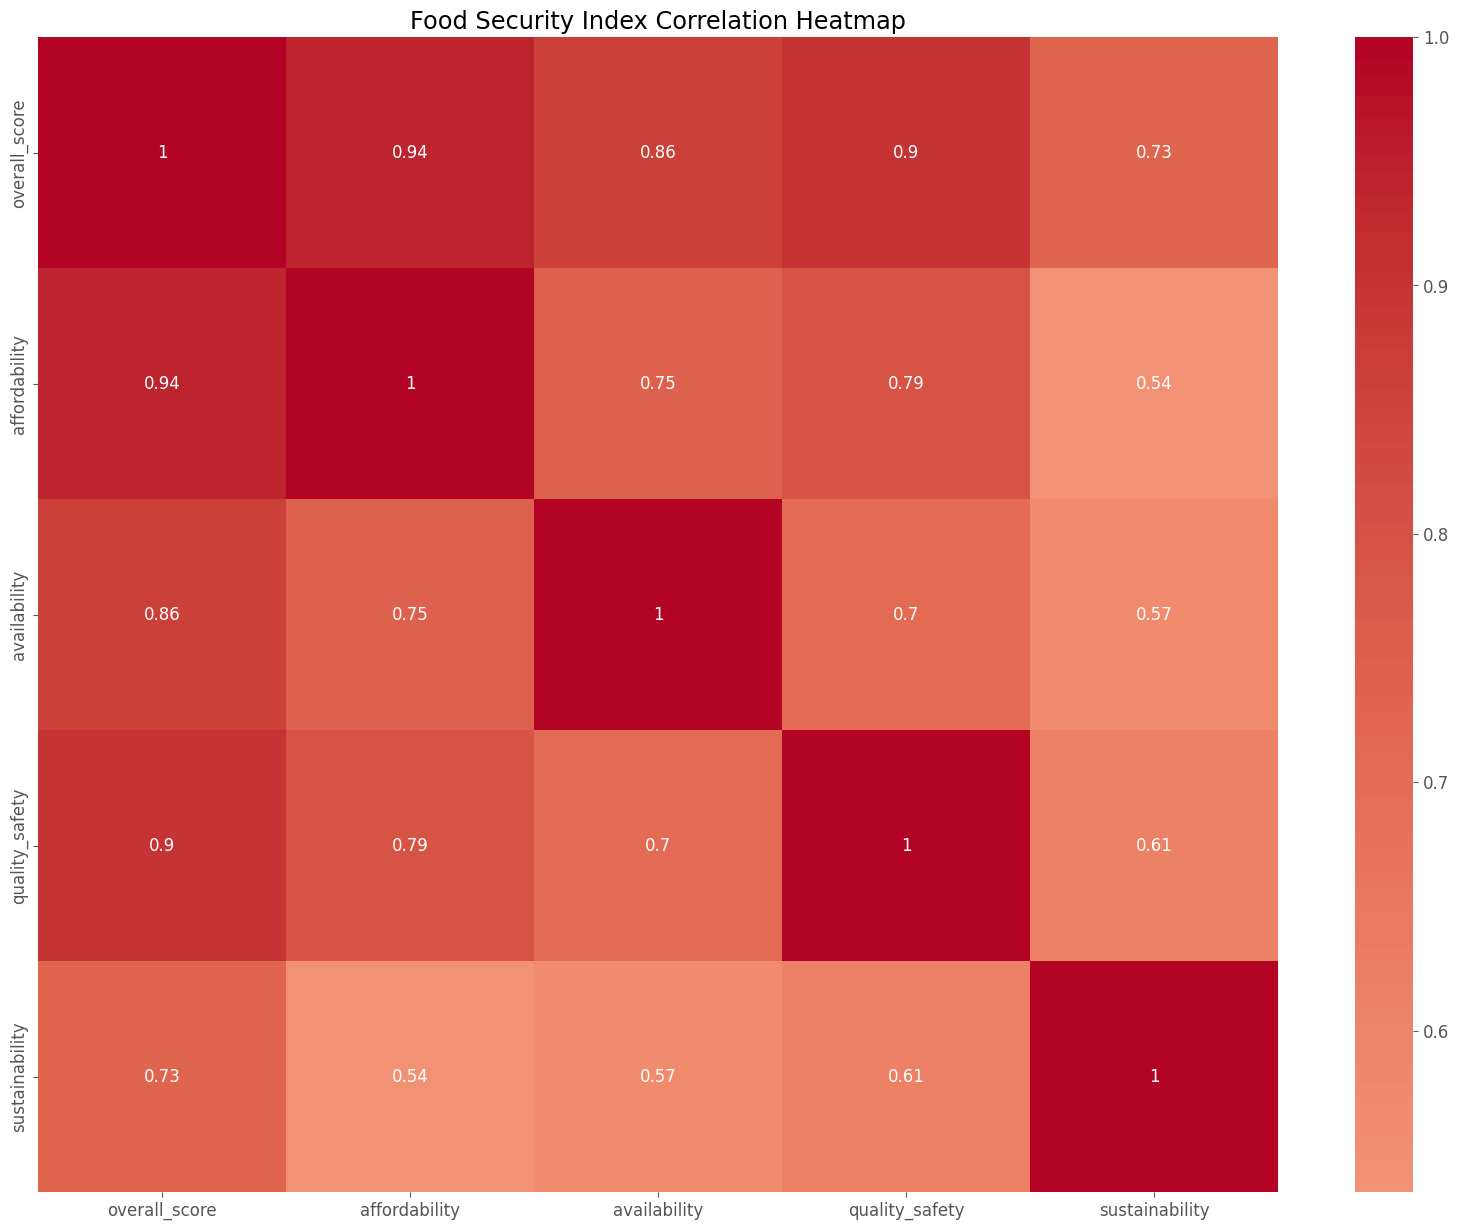

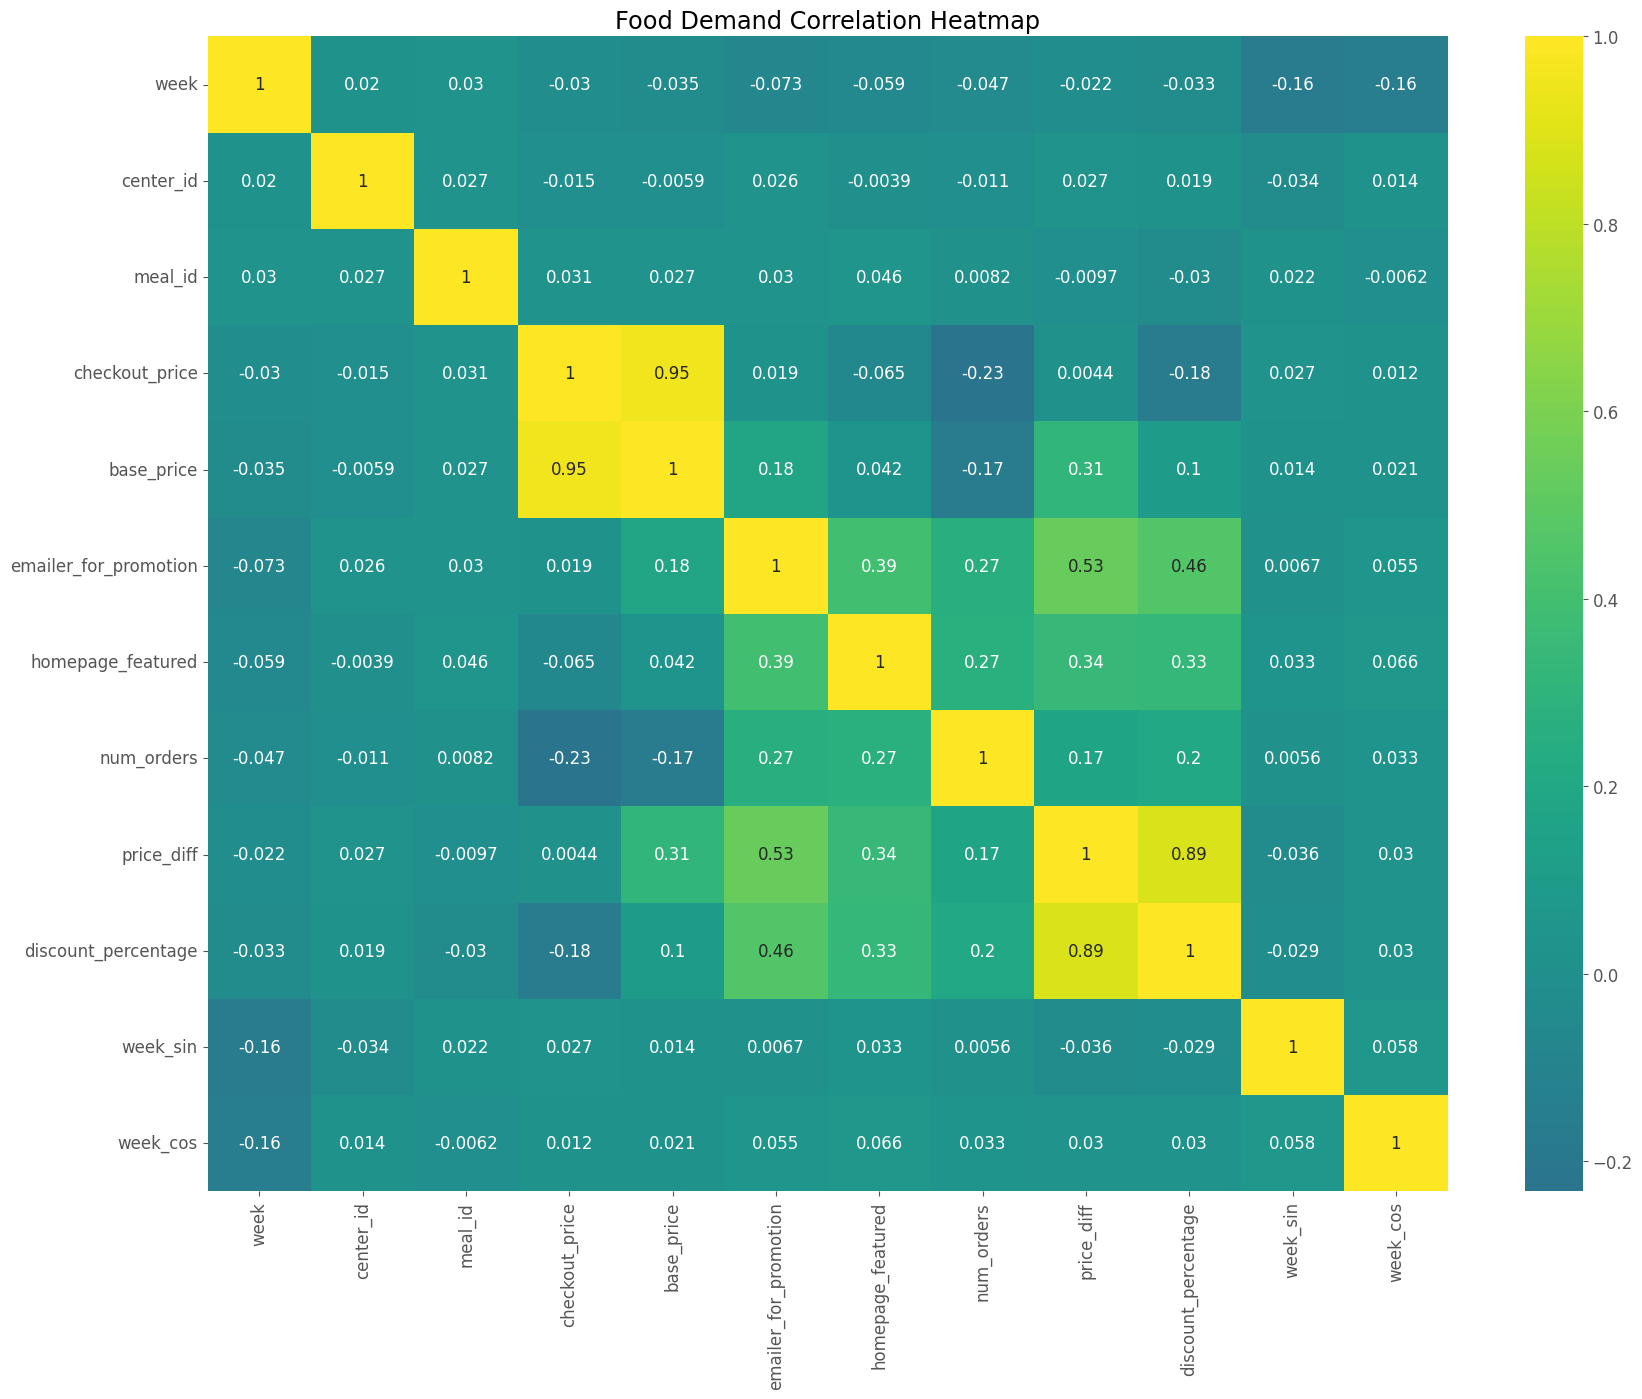

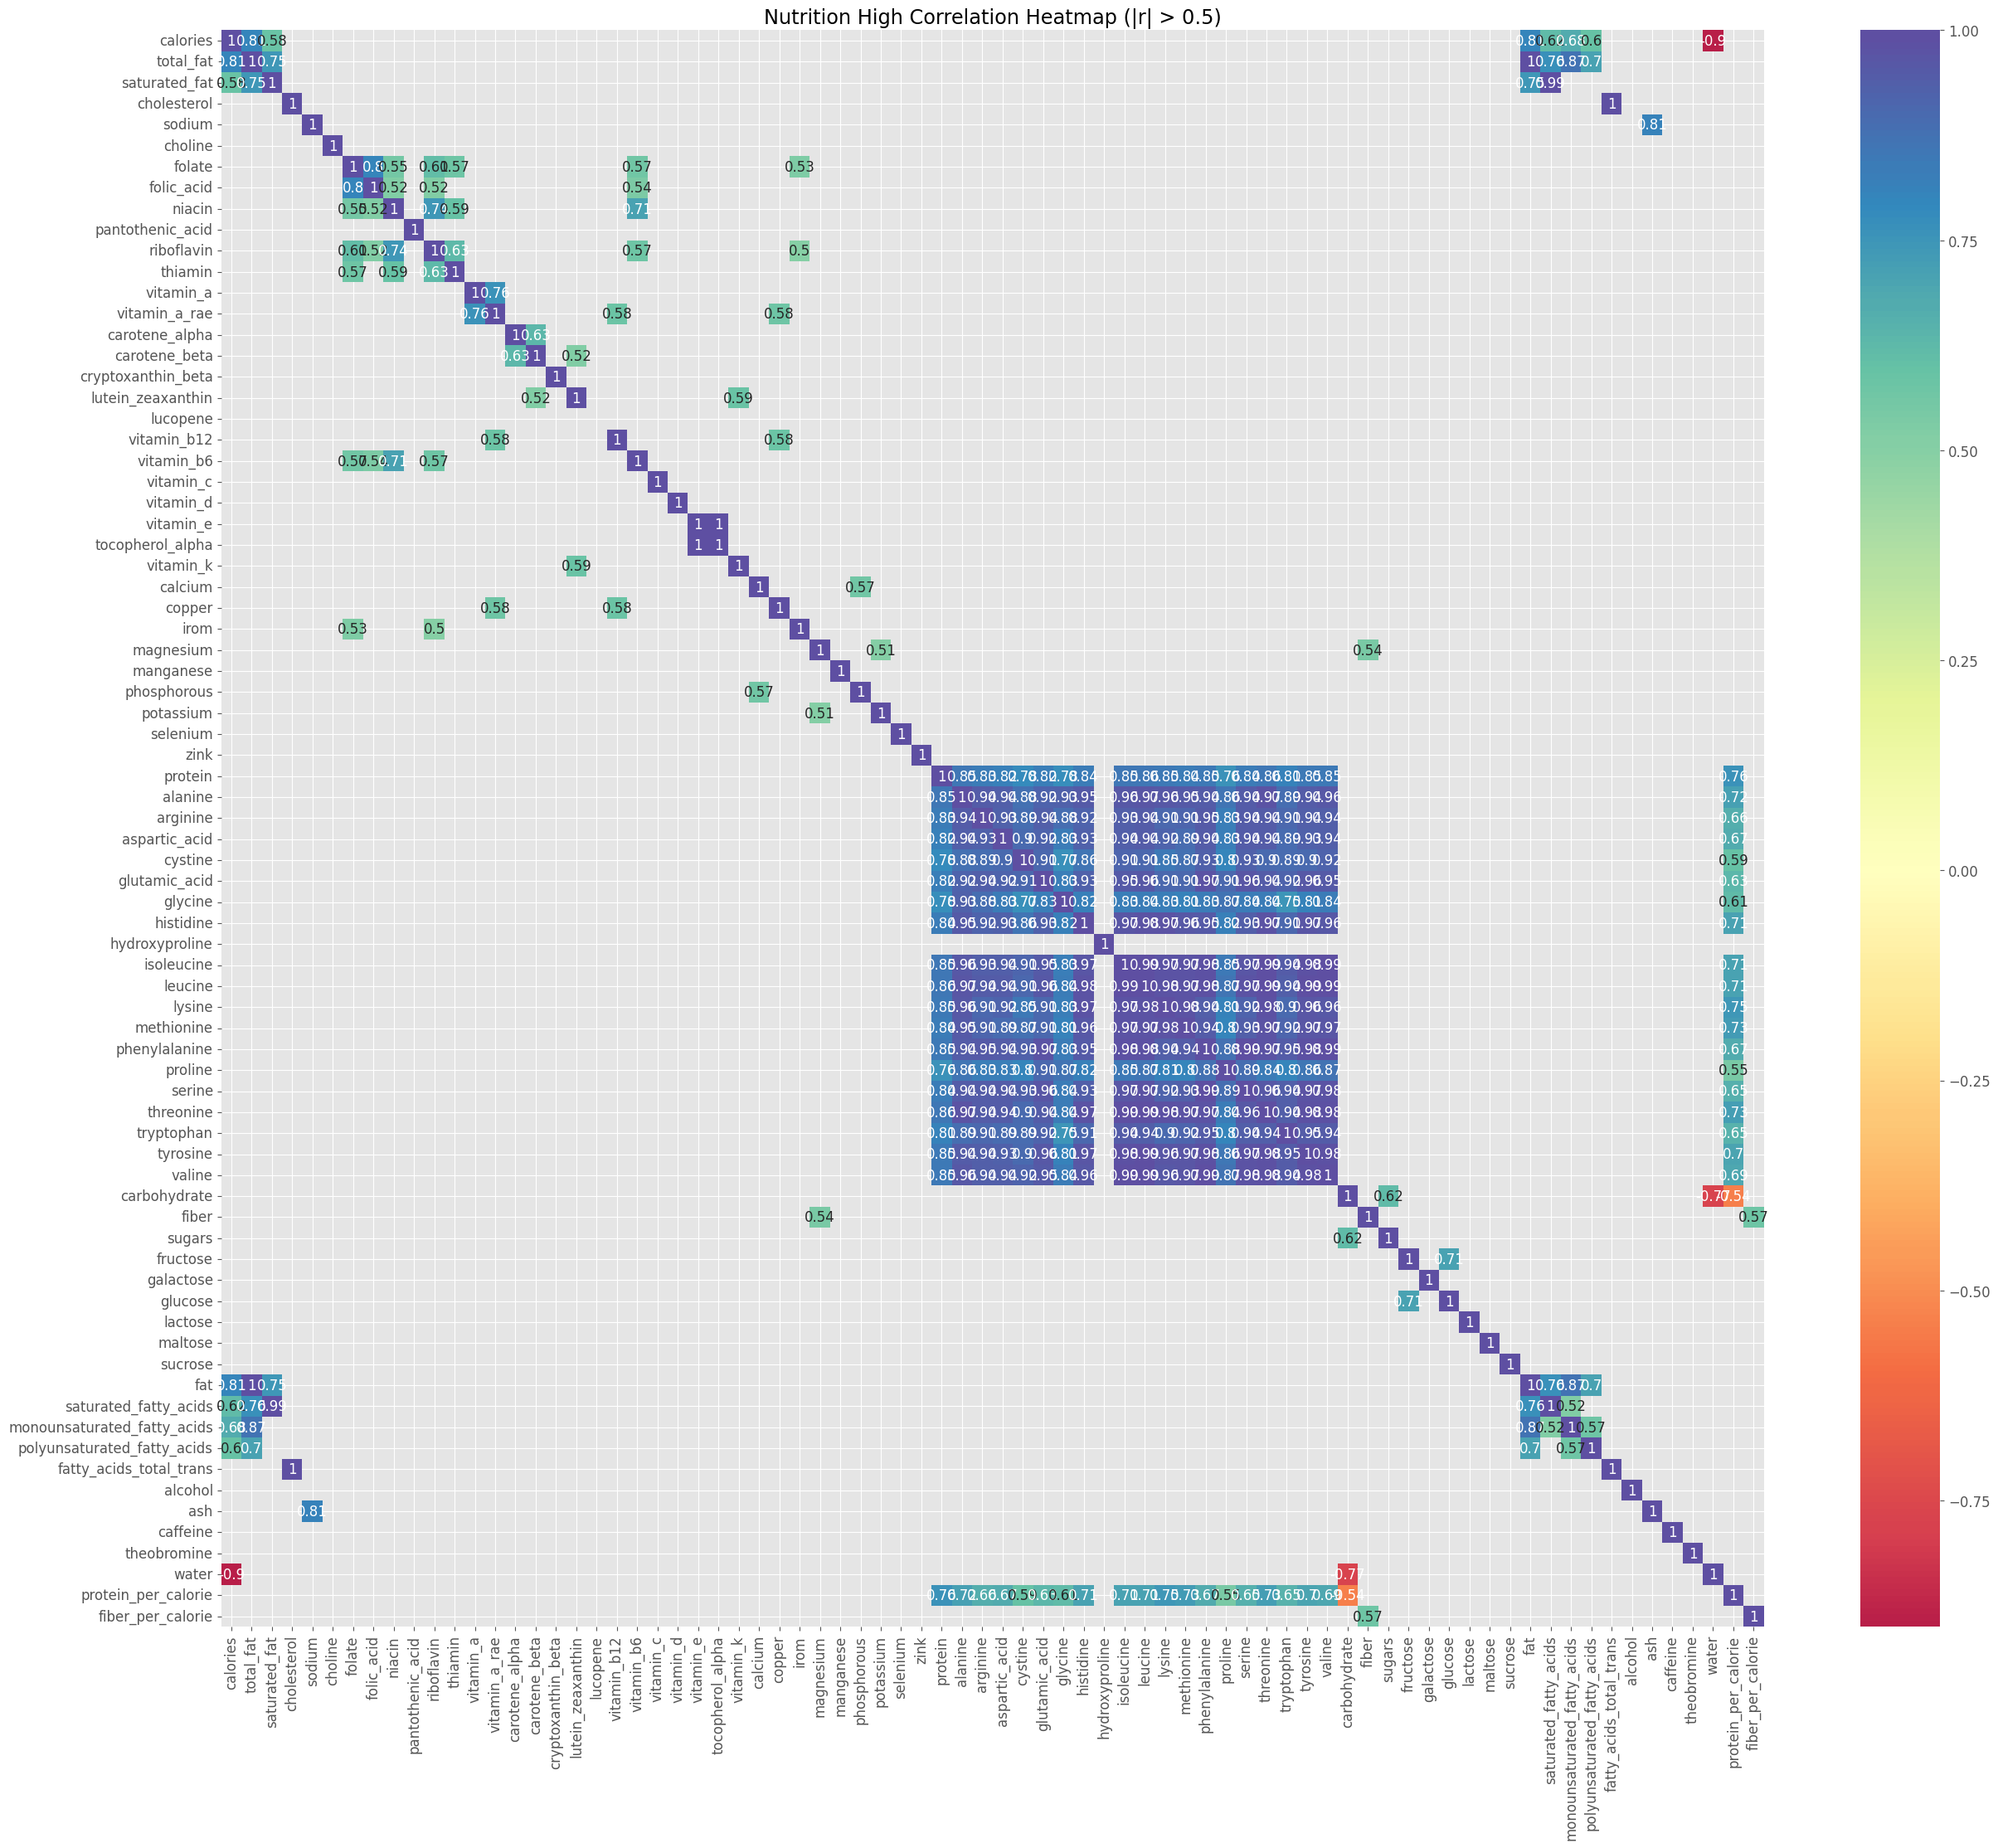

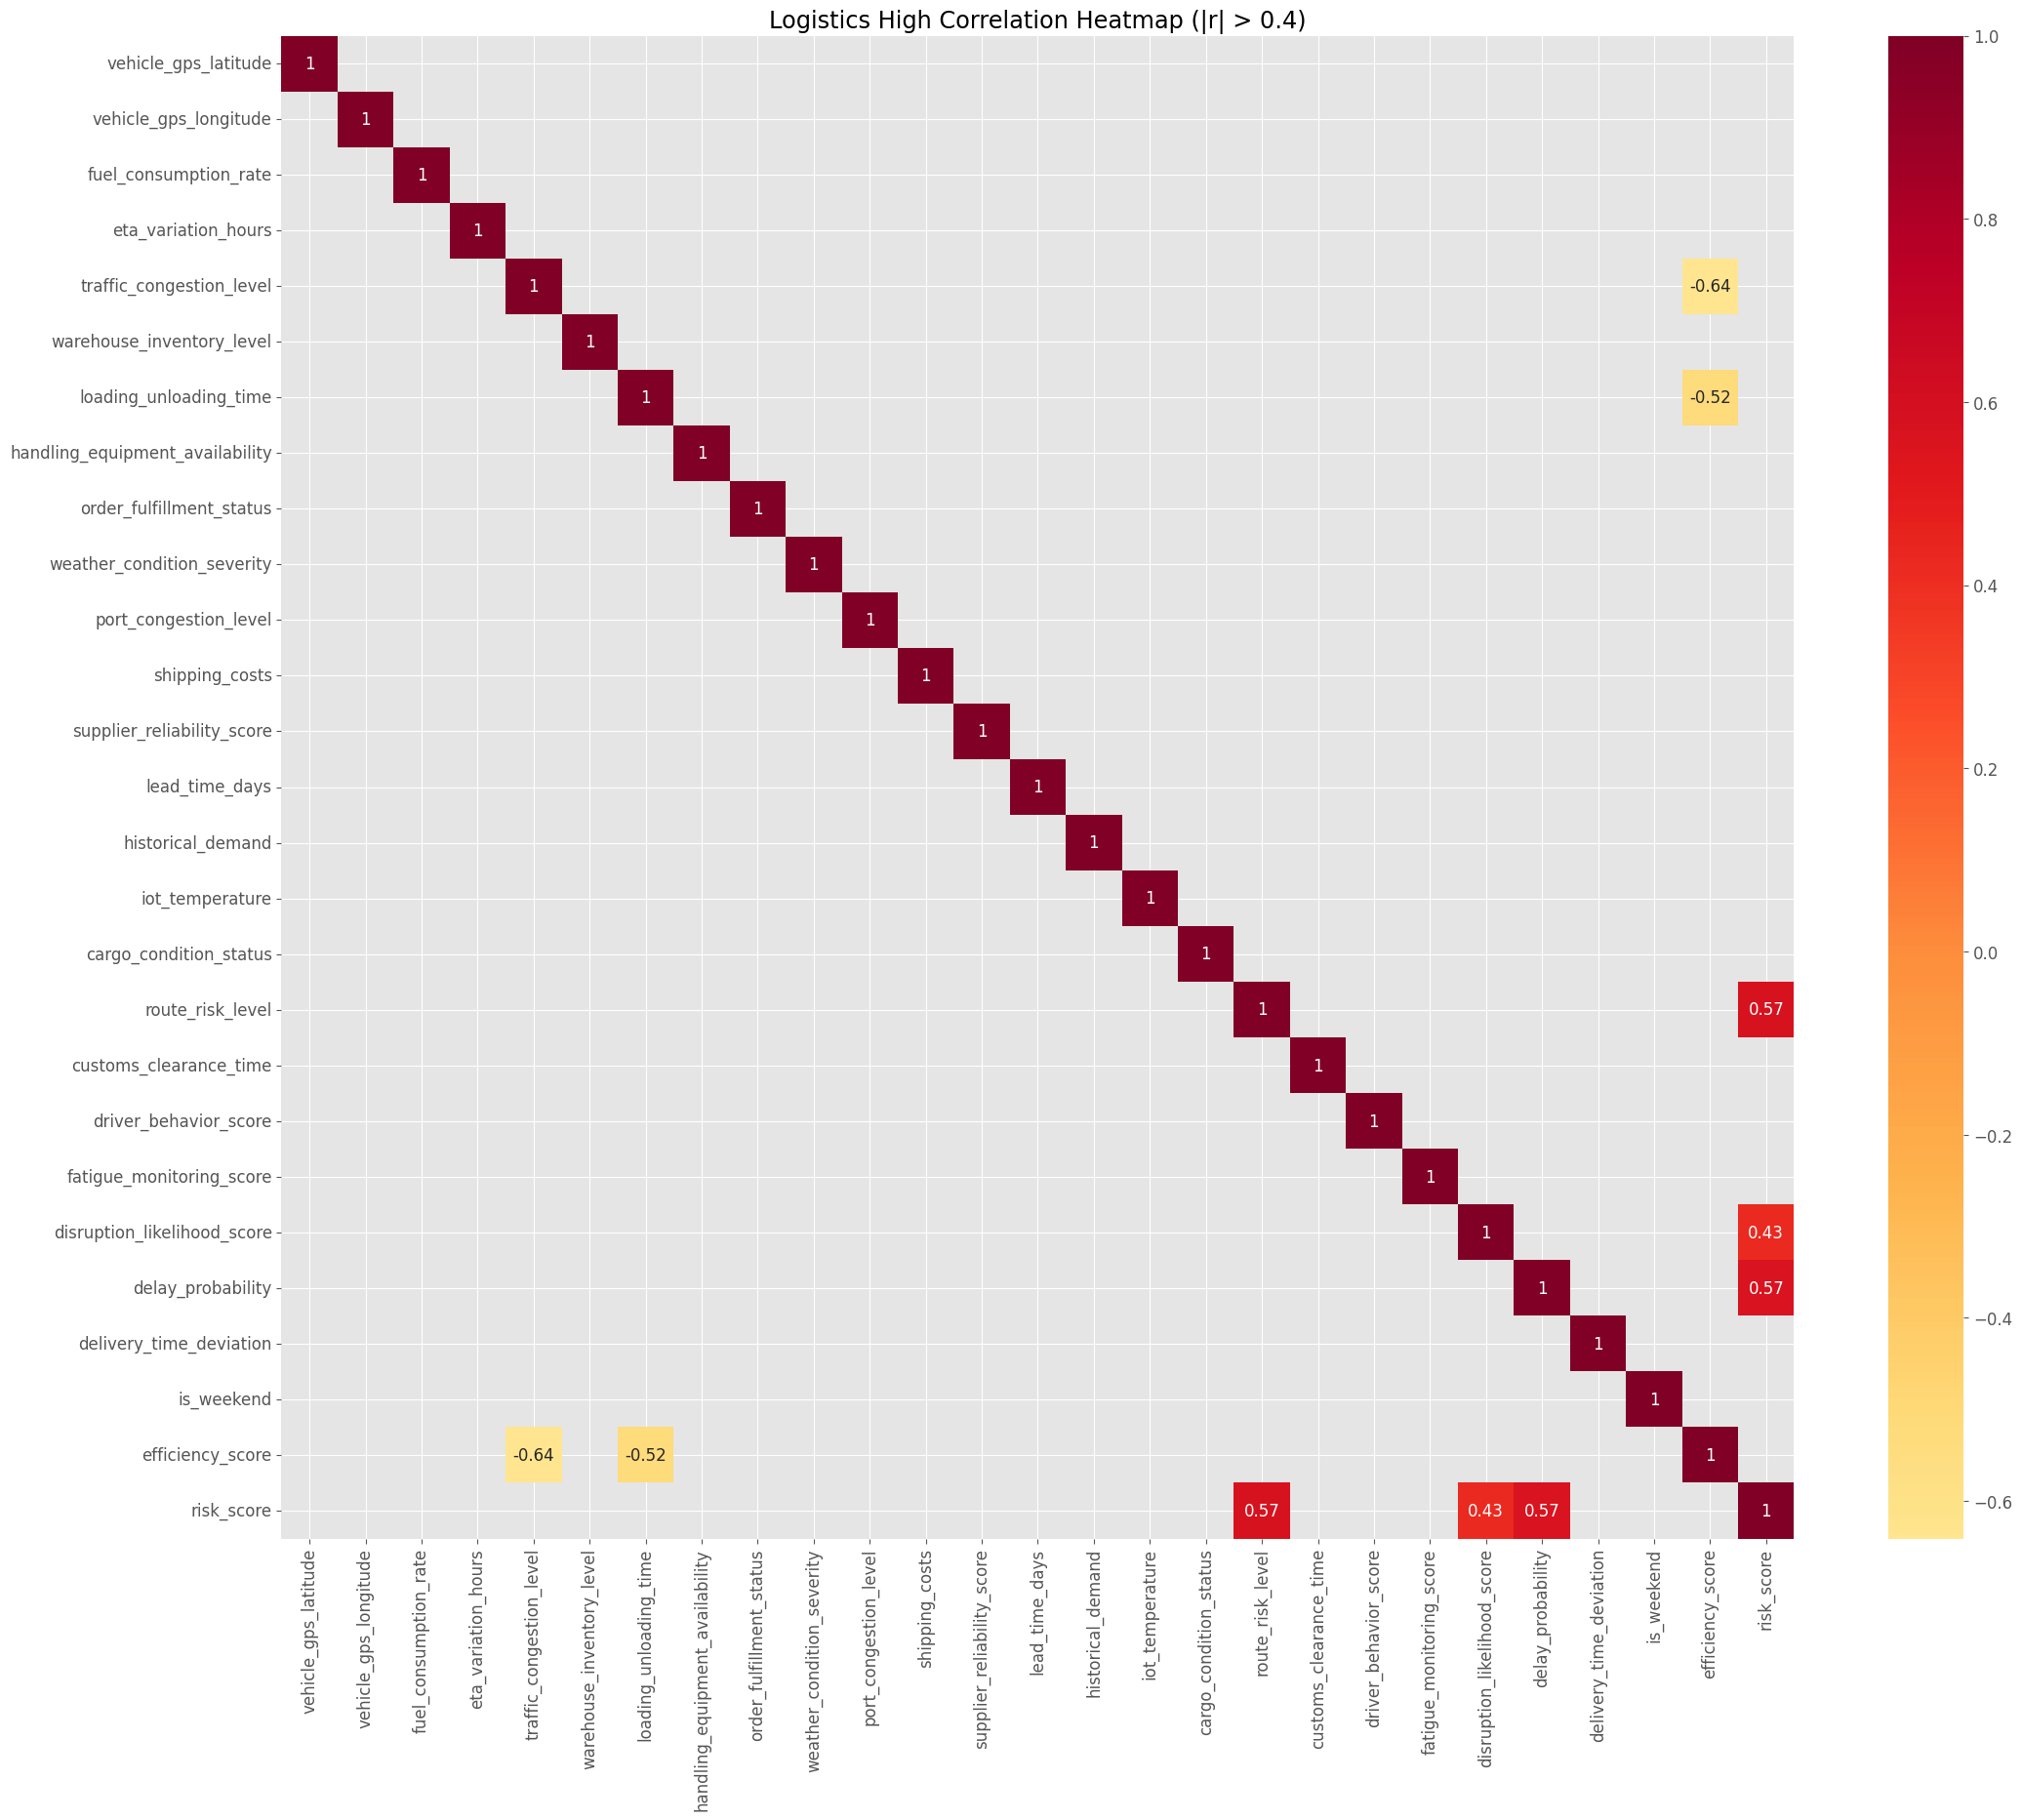

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(food_security.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Food Security Index Correlation Heatmap')
plt.show()

plt.figure(figsize=(20,15))
sns.heatmap(food_demand.corr(), annot=True, cmap='viridis', center=0)
plt.title('Food Demand Correlation Heatmap')
plt.show()

nutrition_corr = nutrition.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(30,25))
sns.heatmap(nutrition_corr[nutrition_corr.abs() > 0.5], annot=True, cmap='Spectral', center=0)
plt.title('Nutrition High Correlation Heatmap (|r| > 0.5)')
plt.show()

logistics_corr = logistics.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(25,20))
sns.heatmap(logistics_corr[logistics_corr.abs() > 0.4], annot=True, cmap='YlOrRd', center=0)
plt.title('Logistics High Correlation Heatmap (|r| > 0.4)')
plt.show()

In [ ]:
fig = make_subplots(rows=2, cols=3, subplot_titles=('Overall Score', 'Affordability', 'Availability', 'Quality & Safety', 'Sustainability', 'Undernourishment %'))

fig.add_trace(go.Histogram(x=food_security['overall_score'], nbinsx=30, name='Overall Score'), row=1, col=1)
fig.add_trace(go.Histogram(x=food_security['affordability'], nbinsx=30, name='Affordability'), row=1, col=2)
fig.add_trace(go.Histogram(x=food_security['availability'], nbinsx=30, name='Availability'), row=1, col=3)
fig.add_trace(go.Histogram(x=food_security['quality_safety'], nbinsx=30, name='Quality & Safety'), row=2, col=1)
fig.add_trace(go.Histogram(x=food_security['sustainability'], nbinsx=30, name='Sustainability'), row=2, col=2)
fig.add_trace(go.Histogram(x=zero_hunger['undernourishment_percent'], nbinsx=30, name='Undernourishment %'), row=2, col=3)

fig.update_layout(height=800, width=1200, title_text="Food Security Distribution Plots")
fig.show()

In [ ]:

print("\nMissing values in key columns:")
print(logistics[['timestamp', 'fuel_consumption_rate', 'traffic_congestion_level', 'efficiency_score']].isnull().sum())


required_cols = ['timestamp', 'fuel_consumption_rate', 'traffic_congestion_level', 'efficiency_score']
if not all(col in logistics.columns for col in required_cols):
    missing = [col for col in required_cols if col not in logistics.columns]
    raise ValueError(f"Missing required columns: {missing}")


for col in ['fuel_consumption_rate', 'traffic_congestion_level', 'efficiency_score']:
    logistics[col] = pd.to_numeric(logistics[col], errors='coerce')


logistics_clean = logistics.dropna(subset=required_cols)


logistics_daily = logistics_clean.resample('D', on='timestamp')[['fuel_consumption_rate', 'traffic_congestion_level', 'efficiency_score']].mean()


fig = go.Figure()
for col, color in zip(['fuel_consumption_rate', 'traffic_congestion_level', 'efficiency_score'],
                      ['royalblue', 'firebrick', 'green']):
    fig.add_trace(go.Scatter(
        x=logistics_daily.index,
        y=logistics_daily[col],
        name=col.replace('_', ' ').title(),
        line=dict(color=color, width=2),
        hovertemplate='Date: %{x}<br>Value: %{y:.2f}<extra></extra>'
    ))

fig.update_layout(
    title='Logistics Metrics Daily Averages',
    xaxis_title='Date',
    yaxis_title='Metric Value',
    hovermode='x unified',
    template='plotly_white',
    legend_title='Metrics',
    height=600
)

fig.show()


Missing values in key columns:
timestamp                   0
fuel_consumption_rate       0
traffic_congestion_level    0
efficiency_score            0
dtype: int64


In [ ]:
merged_food = pd.merge(food_security, zero_hunger[zero_hunger['Year'] == 2020], left_on='country', right_on='Entity', how='left')
fig = px.choropleth(merged_food,
                    locations="Code",
                    color="undernourishment_percent",
                    hover_name="country",
                    hover_data=["overall_score", "affordability", "availability"],
                    color_continuous_scale=px.colors.sequential.Reds,
                    title="Global Undernourishment Prevalence (2020)")
fig.show()

In [ ]:
#food insecurity prediction model

RMSE: 8.48


<Figure size 1000x800 with 0 Axes>

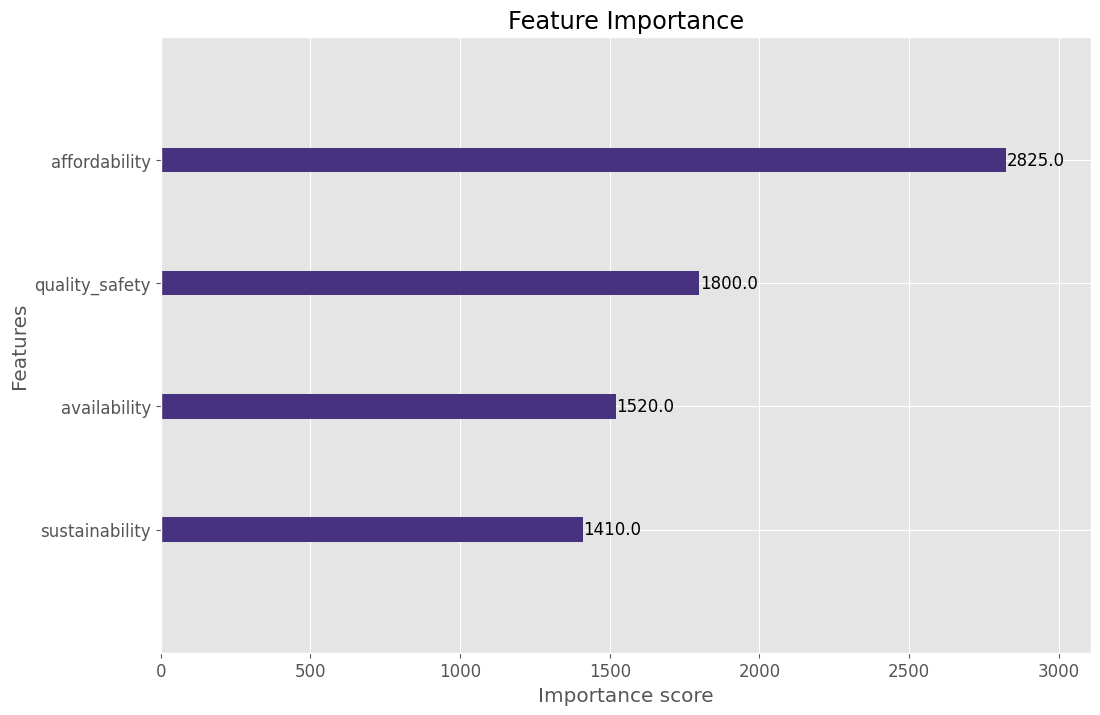

In [ ]:
X_food = merged_food[['affordability', 'availability', 'quality_safety', 'sustainability']]
y_food = merged_food['undernourishment_percent'].fillna(merged_food['undernourishment_percent'].median())

X_train, X_test, y_train, y_test = train_test_split(X_food, y_food, test_size=0.2, random_state=42)


food_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    eval_metric='rmse'
)


food_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


y_pred = food_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


plt.figure(figsize=(10,8))
xgb.plot_importance(food_model)
plt.title('Feature Importance')
plt.show()

Demand Forecasting RMSE: 242.41


<Figure size 1000x600 with 0 Axes>

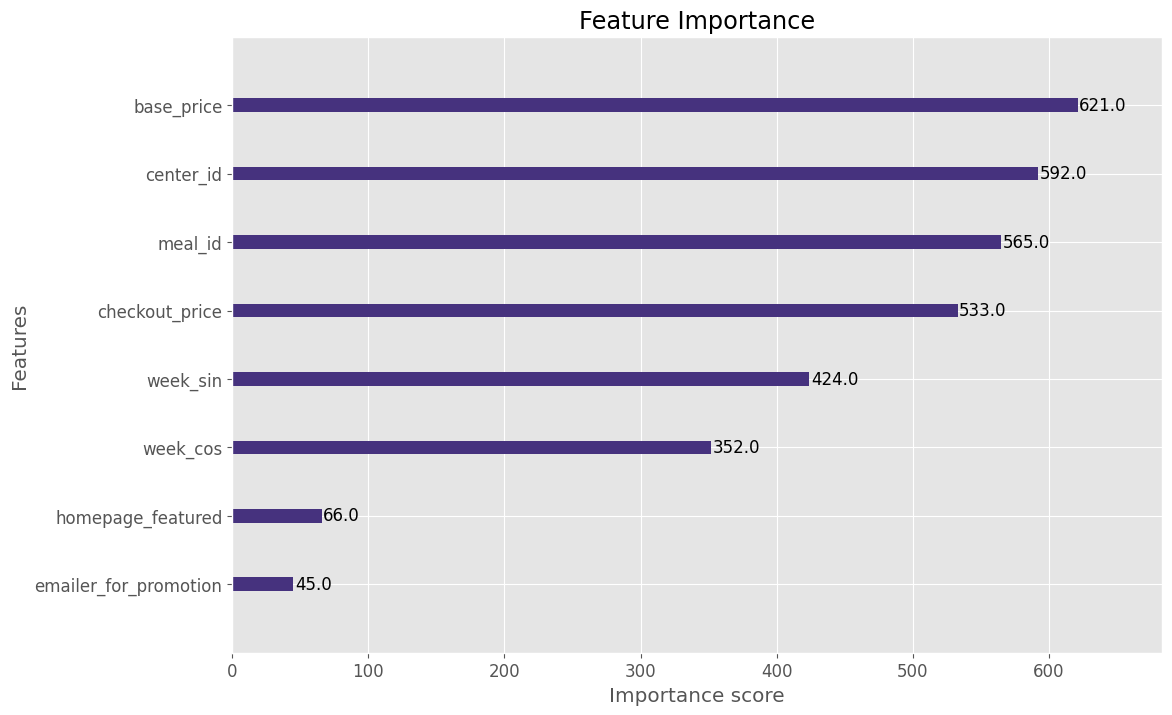

In [ ]:

dtrain = xgb.DMatrix(X_train_d, label=y_train_d)
dtest = xgb.DMatrix(X_test_d, label=y_test_d)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

demand_model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_d = demand_model.predict(dtest)
rmse_d = np.sqrt(mean_squared_error(y_test_d, y_pred_d))
print(f"Demand Forecasting RMSE: {rmse_d:.2f}")


plt.figure(figsize=(10, 6))
xgb.plot_importance(demand_model)
plt.title('Feature Importance')
plt.show()


fig = px.scatter(
    x=y_test_d,
    y=y_pred_d,
    labels={'x': 'Actual Demand', 'y': 'Predicted Demand'},
    title='Actual vs Predicted Food Demand'
)
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=max(y_test_d),
    y1=max(y_test_d),
    line=dict(color='red', dash='dash')
)
fig.update_layout(
    xaxis_title='Actual Demand (orders)',
    yaxis_title='Predicted Demand (orders)',
    showlegend=False
)
fig.show()

Logistics Efficiency RMSE: 0.0864


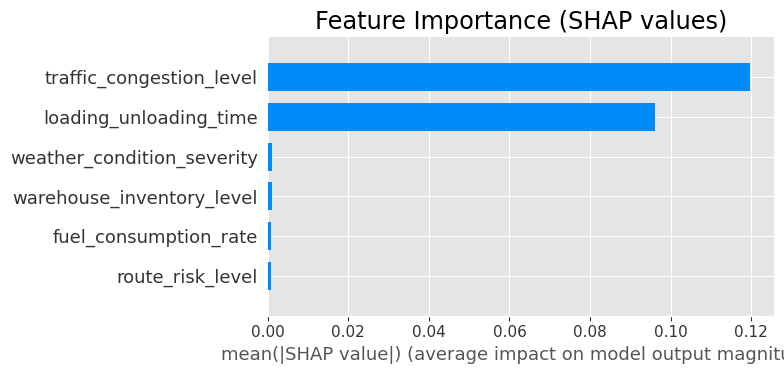

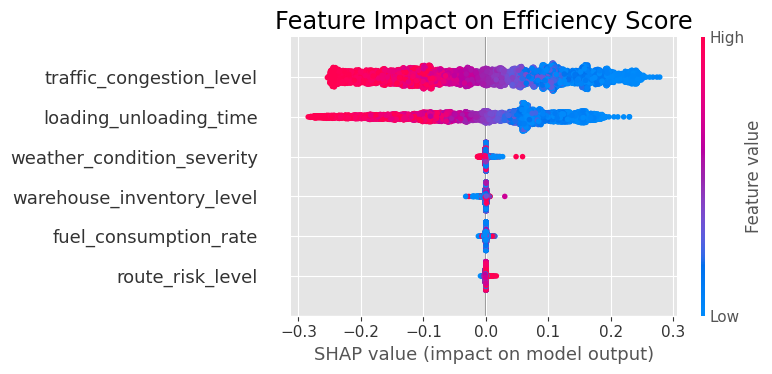

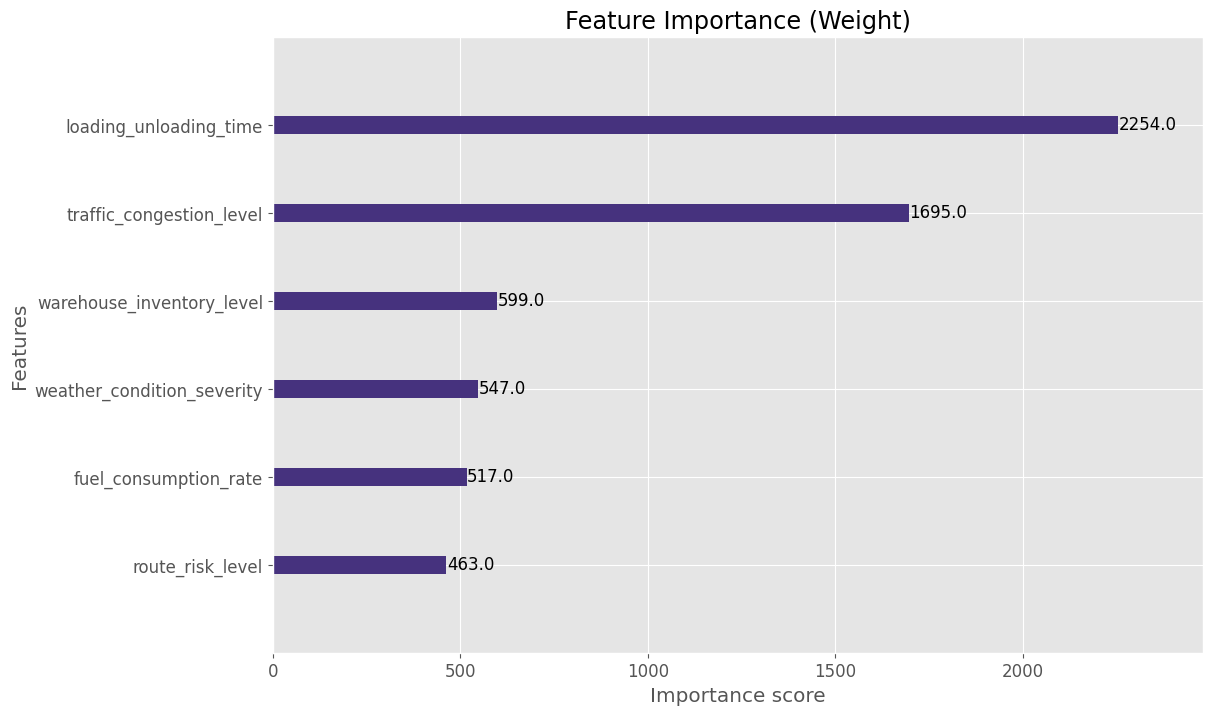

In [ ]:



X_log = logistics[['fuel_consumption_rate', 'traffic_congestion_level', 'warehouse_inventory_level',
                  'loading_unloading_time', 'weather_condition_severity', 'route_risk_level']]
y_log = logistics['efficiency_score']


X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_log, y_log, test_size=0.2, random_state=42)


log_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    early_stopping_rounds=20,
    eval_metric='rmse'
)

log_model.fit(
    X_train_l,
    y_train_l,
    eval_set=[(X_train_l, y_train_l), (X_test_l, y_test_l)],
    verbose=False
)


"""
dtrain = xgb.DMatrix(X_train_l, label=y_train_l)
dtest = xgb.DMatrix(X_test_l, label=y_test_l)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'eval_metric': 'rmse'
}

log_model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=False
)
"""


y_pred_l = log_model.predict(X_test_l)
rmse_l = np.sqrt(mean_squared_error(y_test_l, y_pred_l))
print(f"Logistics Efficiency RMSE: {rmse_l:.4f}")


explainer = shap.TreeExplainer(log_model)
shap_values = explainer(X_test_l)


shap.summary_plot(shap_values, X_test_l, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP values)")
plt.tight_layout()
plt.show()


shap.summary_plot(shap_values, X_test_l, plot_type="dot", show=False)
plt.title("Feature Impact on Efficiency Score")
plt.tight_layout()
plt.show()


xgb.plot_importance(log_model, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.94      0.93       108
      medium       0.99      0.99      0.99       979
         low       0.98      0.98      0.98       671

    accuracy                           0.98      1758
   macro avg       0.96      0.97      0.97      1758
weighted avg       0.98      0.98      0.98      1758



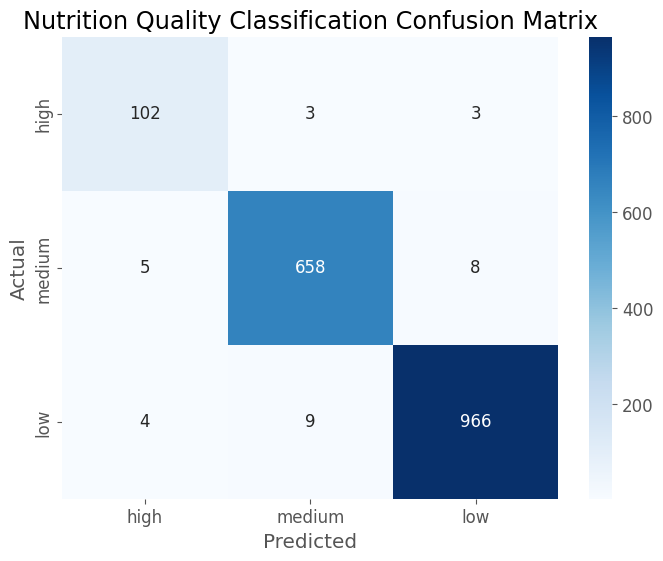

<Figure size 1000x800 with 0 Axes>

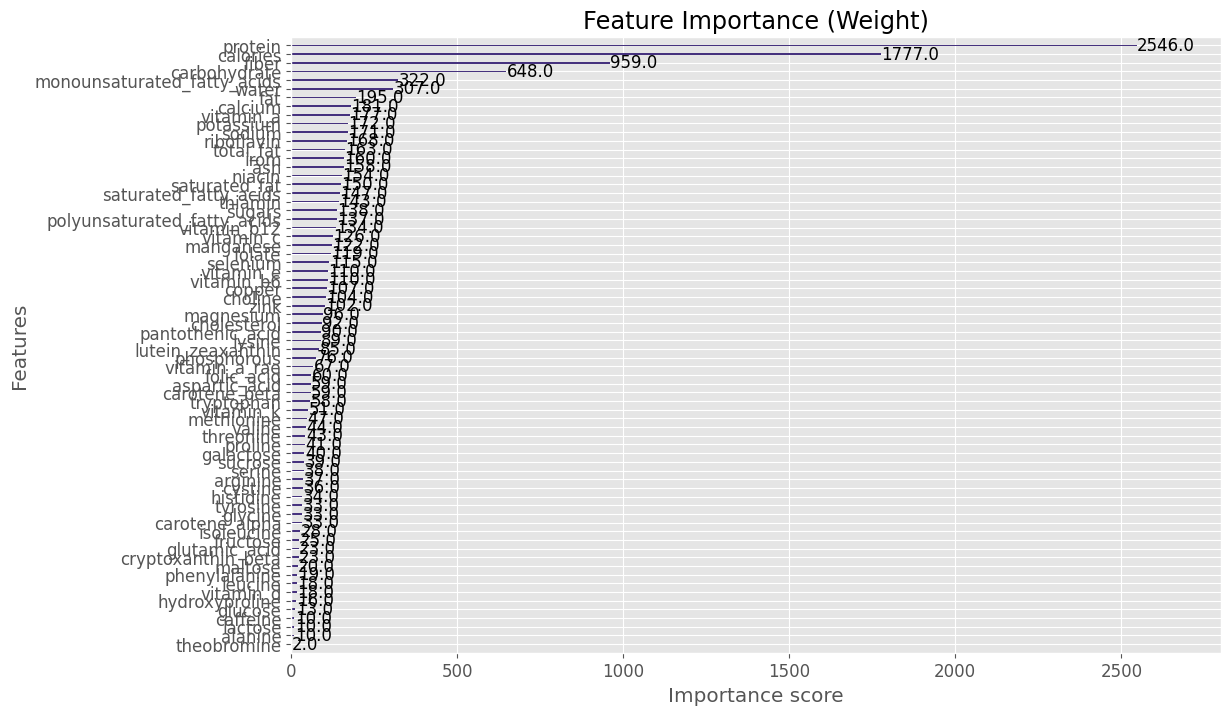

In [ ]:



nutrition['quality'] = np.where(nutrition['protein_per_calorie'] > 0.05,
                              np.where(nutrition['fiber_per_calorie'] > 0.02, 'high', 'medium'), 'low')


X_nut = nutrition.select_dtypes(include=['float64', 'int64']).drop(['protein_per_calorie', 'fiber_per_calorie'], axis=1)
y_nut = nutrition['quality']


X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_nut, y_nut, test_size=0.2, random_state=42)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_n)
y_test_encoded = label_encoder.transform(y_test_n)


nut_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=200,
    learning_rate=0.1,
    early_stopping_rounds=20,
    eval_metric='mlogloss'
)

nut_model.fit(
    X_train_n,
    y_train_encoded,
    eval_set=[(X_train_n, y_train_encoded), (X_test_n, y_test_encoded)],
    verbose=False
)


"""
dtrain = xgb.DMatrix(X_train_n, label=y_train_encoded)
dtest = xgb.DMatrix(X_test_n, label=y_test_encoded)

params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'learning_rate': 0.1,
    'eval_metric': 'mlogloss'
}

nut_model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=False
)
"""


y_pred_encoded = nut_model.predict(X_test_n)
y_pred_n = label_encoder.inverse_transform(y_pred_encoded)


print("Classification Report:")
print(classification_report(y_test_n, y_pred_n, target_names=['high', 'medium', 'low']))


cm = confusion_matrix(y_test_n, y_pred_n, labels=['high', 'medium', 'low'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['high', 'medium', 'low'],
            yticklabels=['high', 'medium', 'low'])
plt.title('Nutrition Quality Classification Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


plt.figure(figsize=(10, 8))
xgb.plot_importance(nut_model, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

In [ ]:
class FoodAllocationEnv(gym.Env):
    def __init__(self, demand_data, nutrition_data, logistics_data):
        super(FoodAllocationEnv, self).__init__()

        self.demand_data = demand_data
        self.nutrition_data = nutrition_data
        self.logistics_data = logistics_data

        self.current_step = 0
        self.max_steps = 100
        self.total_demand = self.demand_data['num_orders'].sum()

        self.action_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "demand": spaces.Box(low=0, high=np.inf, shape=(5,), dtype=np.float32),
            "inventory": spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32),
            "logistics": spaces.Box(low=0, high=10, shape=(4,), dtype=np.float32)
        })

        self.reset()

    def reset(self):
        self.current_step = 0
        self.inventory = {
            'high_quality': 1000,
            'medium_quality': 2000,
            'low_quality': 3000
        }
        self.delivered = {
            'high_quality': 0,
            'medium_quality': 0,
            'low_quality': 0
        }
        self.unmet_demand = 0
        self.total_reward = 0

        demand_sample = self.demand_data.sample(5)
        logistics_sample = self.logistics_data.sample(1)

        observation = {
            "demand": demand_sample['num_orders'].values,
            "inventory": np.array([self.inventory['high_quality'],
                                 self.inventory['medium_quality'],
                                 self.inventory['low_quality']]),
            "logistics": np.array([logistics_sample['efficiency_score'].values[0],
                                  logistics_sample['traffic_congestion_level'].values[0],
                                  logistics_sample['fuel_consumption_rate'].values[0],
                                  logistics_sample['route_risk_level'].values[0]])
        }

        return observation

    def step(self, action):
        action = np.clip(action, 0, 1)
        allocation = {
            'high_quality': action[0],
            'medium_quality': action[1],
            'low_quality': action[2]
        }

        demand_sample = self.demand_data.sample(5)
        current_demand = demand_sample['num_orders'].sum()
        logistics_sample = self.logistics_data.sample(1)
        efficiency = logistics_sample['efficiency_score'].values[0]

        total_allocation = sum(allocation.values())
        if total_allocation > 0:
            normalized_allocation = {k: v/total_allocation for k, v in allocation.items()}
        else:
            normalized_allocation = {'high_quality': 0.33, 'medium_quality': 0.33, 'low_quality': 0.34}

        delivered = {}
        for quality in allocation:
            possible_delivery = min(self.inventory[quality], current_demand * normalized_allocation[quality] * efficiency)
            delivered[quality] = possible_delivery
            self.inventory[quality] -= possible_delivery
            self.delivered[quality] += possible_delivery

        total_delivered = sum(delivered.values())
        unmet_demand = max(0, current_demand - total_delivered)
        self.unmet_demand += unmet_demand

        nutritional_value = (delivered['high_quality'] * 3 + delivered['medium_quality'] * 2 + delivered['low_quality'] * 1)

        reward = (total_delivered * 0.5 + nutritional_value * 0.3 - unmet_demand * 0.2) / 1000
        self.total_reward += reward

        self.current_step += 1
        done = self.current_step >= self.max_steps

        next_observation = {
            "demand": demand_sample['num_orders'].values,
            "inventory": np.array([self.inventory['high_quality'],
                                 self.inventory['medium_quality'],
                                 self.inventory['low_quality']]),
            "logistics": np.array([logistics_sample['efficiency_score'].values[0],
                                  logistics_sample['traffic_congestion_level'].values[0],
                                  logistics_sample['fuel_consumption_rate'].values[0],
                                  logistics_sample['route_risk_level'].values[0]])
        }

        info = {
            "total_delivered": sum(self.delivered.values()),
            "nutritional_value": (self.delivered['high_quality'] * 3 +
                                 self.delivered['medium_quality'] * 2 +
                                 self.delivered['low_quality'] * 1),
            "unmet_demand": self.unmet_demand,
            "inventory_remaining": sum(self.inventory.values())
        }

        return next_observation, reward, done, info

    def render(self, mode='human'):
        print(f"Step: {self.current_step}")
        print(f"Inventory: {self.inventory}")
        print(f"Delivered: {self.delivered}")
        print(f"Unmet Demand: {self.unmet_demand}")
        print(f"Total Reward: {self.total_reward:.2f}")

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        state_input = Input(shape=(self.state_size,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(self.action_size, activation='linear')(x)
        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.action_size)
        state_flat = np.concatenate([state['demand'], state['inventory'], state['logistics']])
        act_values = self.model.predict(state_flat.reshape(1, -1), verbose=0)
        return act_values[0]

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            state_flat = np.concatenate([state['demand'], state['inventory'], state['logistics']])
            next_state_flat = np.concatenate([next_state['demand'], next_state['inventory'], next_state['logistics']])

            target = self.model.predict(state_flat.reshape(1, -1), verbose=0)
            if done:
                target[0][:len(action)] = reward
            else:
                t = self.target_model.predict(next_state_flat.reshape(1, -1), verbose=0)
                target[0][:len(action)] = reward + self.gamma * np.amax(t[0])

            self.model.fit(state_flat.reshape(1, -1), target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Episode: 1/50, Total Reward: -18.79, Epsilon: 0.71, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 123951.0
Episode: 2/50, Total Reward: -18.21, Epsilon: 0.43, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 121061.0
Episode: 3/50, Total Reward: -22.16, Epsilon: 0.26, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 140795.0
Episode: 4/50, Total Reward: -17.70, Epsilon: 0.16, Delivered: 5999.999999999998, Nutrition: 9999.999999999998, Unmet: 118485.0
Episode: 5/50, Total Reward: -17.18, Epsilon: 0.10, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 115879.0
Episode: 6/50, Total Reward: -17.98, Epsilon: 0.06, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 119897.0
Episode: 7/50, Total Reward: -16.87, Epsilon: 0.04, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 114330.0
Episode: 8/50, Total Reward: -22.24, Epsilon: 0.02, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 141224.0
Episode: 9/50, Total Reward: -19.68, Epsilon: 0.01, Delivered: 6000.0, Nutrition: 10000.0, Unmet: 128401.0
Episode: 10/50, 

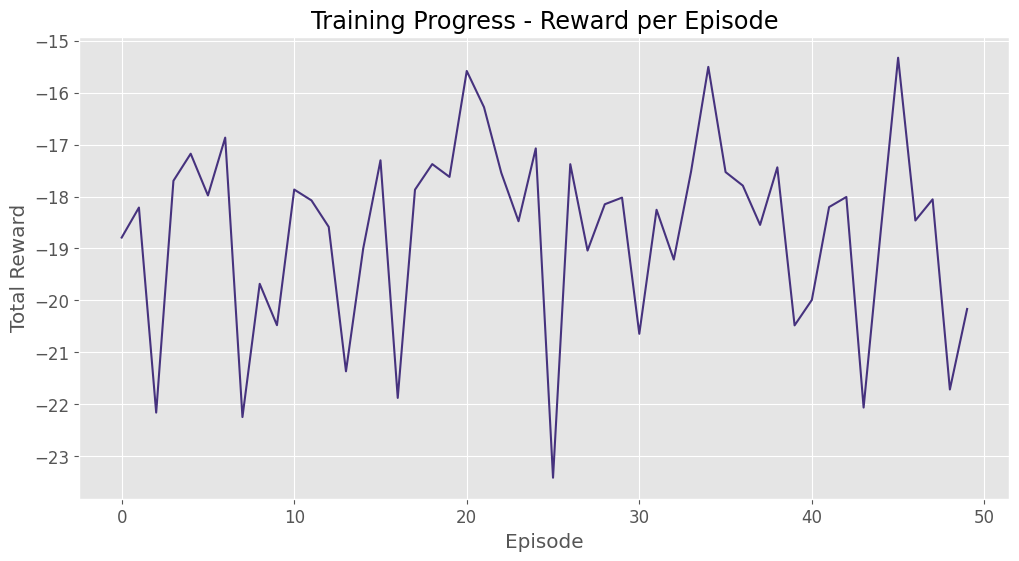

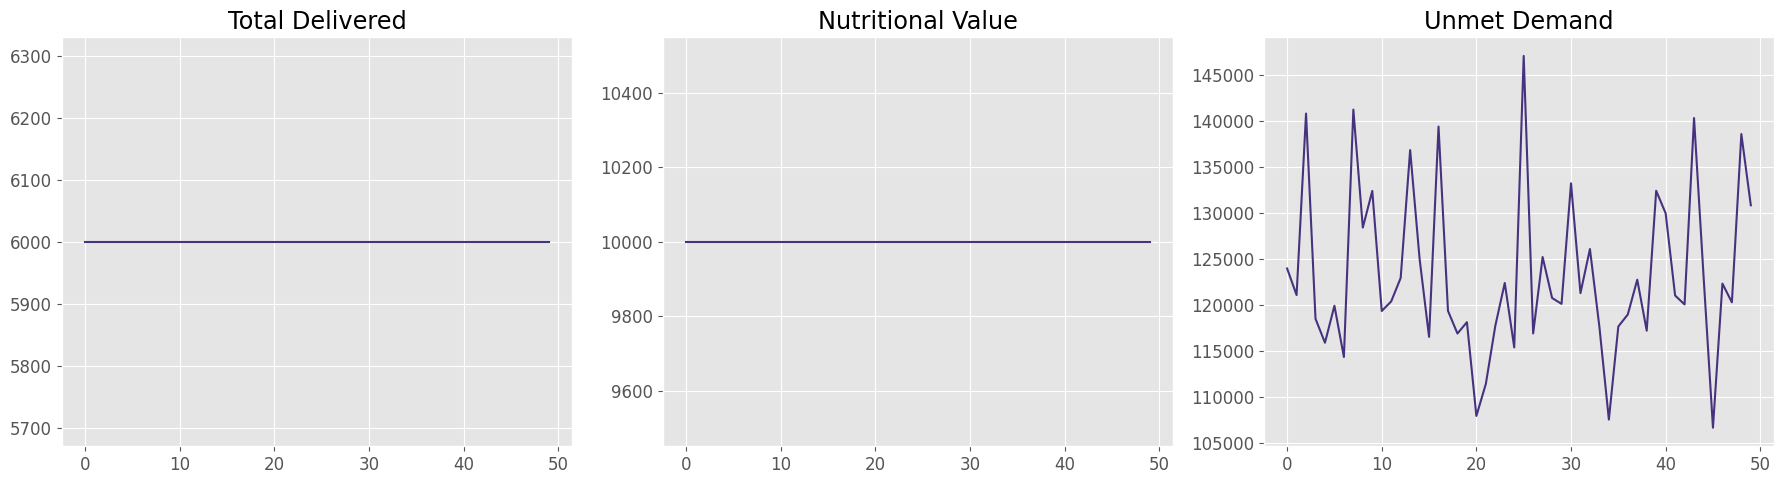

Evaluation Episode 1:
  Total Delivered: 6000.0
  Nutritional Value: 10000.0
  Unmet Demand: 116799.0
  Inventory Remaining: 0.0
  Total Reward: -17.36

Evaluation Episode 2:
  Total Delivered: 6000.0
  Nutritional Value: 10000.0
  Unmet Demand: 117027.0
  Inventory Remaining: 0.0
  Total Reward: -17.41

Evaluation Episode 3:
  Total Delivered: 6000.000000000001
  Nutritional Value: 10000.0
  Unmet Demand: 110096.0
  Inventory Remaining: 0.0
  Total Reward: -16.02

Evaluation Episode 4:
  Total Delivered: 6000.0
  Nutritional Value: 10000.0
  Unmet Demand: 114146.0
  Inventory Remaining: 0.0
  Total Reward: -16.83

Evaluation Episode 5:
  Total Delivered: 6000.0
  Nutritional Value: 9999.999999999998
  Unmet Demand: 124613.0
  Inventory Remaining: 0.0
  Total Reward: -18.92

Evaluation Episode 6:
  Total Delivered: 6000.0
  Nutritional Value: 10000.0
  Unmet Demand: 116761.0
  Inventory Remaining: 0.0
  Total Reward: -17.35

Evaluation Episode 7:
  Total Delivered: 5999.999999999998
  

In [ ]:
import random  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go


np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

class FoodAllocationEnv(gym.Env):
    def __init__(self, demand_data, nutrition_data, logistics_data):
        super(FoodAllocationEnv, self).__init__()

        self.demand_data = demand_data
        self.nutrition_data = nutrition_data
        self.logistics_data = logistics_data

        self.current_step = 0
        self.max_steps = 100
        self.total_demand = self.demand_data['num_orders'].sum()

        self.action_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "demand": spaces.Box(low=0, high=np.inf, shape=(5,), dtype=np.float32),
            "inventory": spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32),
            "logistics": spaces.Box(low=0, high=10, shape=(4,), dtype=np.float32)
        })

        self.reset()

    def reset(self):
        self.current_step = 0
        self.inventory = {
            'high_quality': 1000,
            'medium_quality': 2000,
            'low_quality': 3000
        }
        self.delivered = {
            'high_quality': 0,
            'medium_quality': 0,
            'low_quality': 0
        }
        self.unmet_demand = 0
        self.total_reward = 0

        demand_sample = self.demand_data.sample(5)
        logistics_sample = self.logistics_data.sample(1)

        observation = {
            "demand": demand_sample['num_orders'].values.astype(np.float32),
            "inventory": np.array([self.inventory['high_quality'],
                                 self.inventory['medium_quality'],
                                 self.inventory['low_quality']], dtype=np.float32),
            "logistics": np.array([logistics_sample['efficiency_score'].values[0],
                                  logistics_sample['traffic_congestion_level'].values[0],
                                  logistics_sample['fuel_consumption_rate'].values[0],
                                  logistics_sample['route_risk_level'].values[0]], dtype=np.float32)
        }

        return observation

    def step(self, action):
        action = np.clip(action, 0, 1)
        allocation = {
            'high_quality': action[0],
            'medium_quality': action[1],
            'low_quality': action[2]
        }

        demand_sample = self.demand_data.sample(5)
        current_demand = demand_sample['num_orders'].sum()
        logistics_sample = self.logistics_data.sample(1)
        efficiency = logistics_sample['efficiency_score'].values[0]

        total_allocation = sum(allocation.values())
        if total_allocation > 0:
            normalized_allocation = {k: v/total_allocation for k, v in allocation.items()}
        else:
            normalized_allocation = {'high_quality': 0.33, 'medium_quality': 0.33, 'low_quality': 0.34}

        delivered = {}
        for quality in allocation:
            possible_delivery = min(self.inventory[quality], current_demand * normalized_allocation[quality] * efficiency)
            delivered[quality] = possible_delivery
            self.inventory[quality] -= possible_delivery
            self.delivered[quality] += possible_delivery

        total_delivered = sum(delivered.values())
        unmet_demand = max(0, current_demand - total_delivered)
        self.unmet_demand += unmet_demand

        nutritional_value = (delivered['high_quality'] * 3 + delivered['medium_quality'] * 2 + delivered['low_quality'] * 1)

        reward = (total_delivered * 0.5 + nutritional_value * 0.3 - unmet_demand * 0.2) / 1000
        self.total_reward += reward

        self.current_step += 1
        done = self.current_step >= self.max_steps

        next_observation = {
            "demand": demand_sample['num_orders'].values.astype(np.float32),
            "inventory": np.array([self.inventory['high_quality'],
                                 self.inventory['medium_quality'],
                                 self.inventory['low_quality']], dtype=np.float32),
            "logistics": np.array([logistics_sample['efficiency_score'].values[0],
                                  logistics_sample['traffic_congestion_level'].values[0],
                                  logistics_sample['fuel_consumption_rate'].values[0],
                                  logistics_sample['route_risk_level'].values[0]], dtype=np.float32)
        }

        info = {
            "total_delivered": sum(self.delivered.values()),
            "nutritional_value": (self.delivered['high_quality'] * 3 +
                                 self.delivered['medium_quality'] * 2 +
                                 self.delivered['low_quality'] * 1),
            "unmet_demand": self.unmet_demand,
            "inventory_remaining": sum(self.inventory.values())
        }

        return next_observation, reward, done, info

    def render(self, mode='human'):
        print(f"Step: {self.current_step}")
        print(f"Inventory: {self.inventory}")
        print(f"Delivered: {self.delivered}")
        print(f"Unmet Demand: {self.unmet_demand}")
        print(f"Total Reward: {self.total_reward:.2f}")

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        state_input = Input(shape=(self.state_size,))
        x = Dense(64, activation='relu')(state_input)
        x = Dense(64, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(self.action_size, activation='linear')(x)
        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        state_flat = np.concatenate([state['demand'], state['inventory'], state['logistics']])
        next_state_flat = np.concatenate([next_state['demand'], next_state['inventory'], next_state['logistics']])
        self.memory.append((state_flat, action, reward, next_state_flat, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.action_size)
        state_flat = np.concatenate([state['demand'], state['inventory'], state['logistics']])
        act_values = self.model.predict(state_flat.reshape(1, -1), verbose=0)
        return act_values[0]

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])

        targets = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            if dones[i]:
                targets[i][:len(actions[i])] = rewards[i]
            else:
                targets[i][:len(actions[i])] = rewards[i] + self.gamma * np.amax(target_next[i])

        self.model.fit(states, targets, epochs=1, verbose=0, batch_size=batch_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

def train_rl_agent(env, episodes=50, batch_size=32):
    state_size = len(env.observation_space['demand'].sample()) + \
                len(env.observation_space['inventory'].sample()) + \
                len(env.observation_space['logistics'].sample())
    action_size = env.action_space.shape[0]

    agent = DQNAgent(state_size, action_size)
    rewards_history = []
    metrics_history = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        rewards_history.append(total_reward)
        metrics_history.append(info)

        print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}, " +
              f"Epsilon: {agent.epsilon:.2f}, Delivered: {info['total_delivered']}, " +
              f"Nutrition: {info['nutritional_value']}, Unmet: {info['unmet_demand']}")

    
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history)
    plt.title('Training Progress - Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

   
    metrics_df = pd.DataFrame(metrics_history)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics_df['total_delivered'].plot(ax=axes[0], title='Total Delivered')
    metrics_df['nutritional_value'].plot(ax=axes[1], title='Nutritional Value')
    metrics_df['unmet_demand'].plot(ax=axes[2], title='Unmet Demand')
    plt.tight_layout()
    plt.show()

    return agent


env = FoodAllocationEnv(food_demand, nutrition, logistics)
trained_agent = train_rl_agent(env)


def evaluate_agent(agent, env, num_episodes=10):
    results = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            total_reward += reward

        results.append(info)
        print(f"Evaluation Episode {episode+1}:")
        print(f"  Total Delivered: {info['total_delivered']}")
        print(f"  Nutritional Value: {info['nutritional_value']}")
        print(f"  Unmet Demand: {info['unmet_demand']}")
        print(f"  Inventory Remaining: {info['inventory_remaining']}")
        print(f"  Total Reward: {total_reward:.2f}\n")

   
    avg_delivered = np.mean([r['total_delivered'] for r in results])
    avg_nutrition = np.mean([r['nutritional_value'] for r in results])
    avg_unmet = np.mean([r['unmet_demand'] for r in results])

    print("\nAverage Performance:")
    print(f"  Avg Delivered: {avg_delivered:.2f}")
    print(f"  Avg Nutrition: {avg_nutrition:.2f}")
    print(f"  Avg Unmet Demand: {avg_unmet:.2f}")


evaluate_agent(trained_agent, env)

In [ ]:
trained_agent.save('food_allocation_agent.weights.h5')

In [ ]:
class FoodResourceChatbot:
    def __init__(self, food_model, demand_model, log_model, nut_model):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        self.food_model = food_model
        self.demand_model = demand_model
        self.log_model = log_model
        self.nut_model = nut_model
        self.context = {}

        self.response_templates = {
            "food_security": "Based on our food security analysis, {country} has an overall score of {score:.1f}. " +
                            "The affordability score is {afford:.1f}, availability is {avail:.1f}, " +
                            "quality/safety is {qual:.1f}, and sustainability is {sust:.1f}. " +
                            "The predicted undernourishment rate is {undernourish:.1f}%.",
            "demand": "Our demand forecasting model predicts {demand:.0f} orders for the given parameters.",
            "logistics": "The logistics efficiency score for these conditions is {score:.2f} (0-1 scale). " +
                        "Key factors affecting efficiency are: {factors}.",
            "nutrition": "This food item is classified as {quality} nutritional quality. " +
                        "It has {protein:.2f}g protein per calorie and {fiber:.2f}g fiber per calorie.",
            "unknown": "I'm not sure how to answer that. I can provide information about: " +
                      "food security, demand forecasting, logistics optimization, or nutrition analysis. " +
                      "You can also visit our platform at https://rescuebiteslanding.vercel.app for more information."
        }

    def process_input(self, text):
        inputs = self.tokenizer(text, return_tensors='tf', truncation=True, max_length=128)
        outputs = self.bert_model(inputs)
        embeddings = outputs.last_hidden_state[:,0,:].numpy()
        return embeddings

    def generate_response(self, user_input):
        embeddings = self.process_input(user_input)

        if any(word in user_input.lower() for word in ['security', 'hunger', 'nourishment', 'country']):
            country = self._extract_country(user_input)
            if country:
                response = self._get_food_security_response(country)
            else:
                response = "Please specify a country for food security information."

        elif any(word in user_input.lower() for word in ['demand', 'order', 'forecast']):
            response = self._get_demand_response(user_input)

        elif any(word in user_input.lower() for word in ['logistics', 'delivery', 'efficiency']):
            response = self._get_logistics_response(user_input)

        elif any(word in user_input.lower() for word in ['nutrition', 'food', 'quality', 'healthy']):
            response = self._get_nutrition_response(user_input)

        else:
            response = self.response_templates["unknown"]

        return response + "\n\nFor more detailed analysis, visit our platform: https://rescuebiteslanding.vercel.app"

    def _extract_country(self, text):
        for country in food_security['country'].unique():
            if country.lower() in text.lower():
                return country
        return None

    def _get_food_security_response(self, country):
        data = food_security[food_security['country'] == country].iloc[0]
        undernourish = self.food_model.predict([[data['affordability'], data['availability'],
                                              data['quality_safety'], data['sustainability']]])[0]

        return self.response_templates["food_security"].format(
            country=country,
            score=data['overall_score'],
            afford=data['affordability'],
            avail=data['availability'],
            qual=data['quality_safety'],
            sust=data['sustainability'],
            undernourish=undernourish
        )

    def _get_demand_response(self, text):
        week = 25 if 'week' not in text else int(text.split('week')[1].split()[0])
        price = 300 if 'price' not in text else int(text.split('price')[1].split()[0])

        week_sin = np.sin(2 * np.pi * week/52)
        week_cos = np.cos(2 * np.pi * week/52)

        prediction = self.demand_model.predict([[week_sin, week_cos, 50, 1500, price, price*1.1, 0, 0]])[0]

        return self.response_templates["demand"].format(demand=prediction)

    def _get_logistics_response(self, text):
        congestion = 5 if 'congestion' not in text else float(text.split('congestion')[1].split()[0])
        risk = 5 if 'risk' not in text else float(text.split('risk')[1].split()[0])

        prediction = self.log_model.predict([[8, congestion, 300, 2, 0.3, risk]])[0]

        factors = "traffic congestion" if congestion > 5 else "route risk" if risk > 5 else "normal conditions"

        return self.response_templates["logistics"].format(score=prediction, factors=factors)

    def _get_nutrition_response(self, text):
        food_item = "chicken" if 'food' not in text else text.split('food')[1].split()[0]

        sample_food = nutrition[nutrition['name'].str.contains(food_item, case=False)].iloc[0]
        quality = self.nut_model.predict([sample_food.select_dtypes(include=['float64', 'int64']).values.reshape(1, -1)])[0]

        return self.response_templates["nutrition"].format(
            quality=quality,
            protein=sample_food['protein_per_calorie'],
            fiber=sample_food['fiber_per_calorie']
        )

In [ ]:
def run_full_pipeline():
    print("Loading and preprocessing data...")

    print("\nTraining predictive models...")

    print("\nSetting up reinforcement learning environment...")

    print("\nInitializing conversational interface...")
    chatbot = FoodResourceChatbot(food_model, demand_model, log_model, nut_model)

    print("\nSystem ready for deployment!")
    print("Visit our platform for the complete experience: https://rescuebiteslanding.vercel.app")

    return {
        'food_model': food_model,
        'demand_model': demand_model,
        'log_model': log_model,
        'nut_model': nut_model,
        'rl_agent': agent,
        'chatbot': chatbot
    }

system = run_full_pipeline()

Loading and preprocessing data...

Training predictive models...

Setting up reinforcement learning environment...

Initializing conversational interface...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


System ready for deployment!
Visit our platform for the complete experience: https://rescuebiteslanding.vercel.app


In [ ]:
system

{'food_model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...),
 'demand_model': <xgboost.core.Booster at 0x7dbb54f31a90>,
 'log_model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                           r2_score, classification_report,
                           confusion_matrix, accuracy_score)
import shap
from transformers import BertTokenizer, TFBertModel


trained_agent = DQNAgent(state_size=12, action_size=3)  # Replace with your actual sizes
trained_agent.model.load_weights('food_allocation_agent.weights.h5')

In [ ]:
def evaluate_food_security_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Food Security Model: Actual vs Predicted')
    plt.show()

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

def evaluate_demand_model(model, X_test, y_test):
    y_pred = model.predict(xgb.DMatrix(X_test))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Demand')
    plt.ylabel('Predicted Demand')
    plt.title('Demand Forecasting: Actual vs Predicted')
    plt.show()

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

def evaluate_logistics_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Efficiency')
    plt.ylabel('Predicted Efficiency')
    plt.title('Logistics Efficiency: Actual vs Predicted')
    plt.show()


    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('Feature Importance (SHAP values)')
    plt.tight_layout()
    plt.show()

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

def evaluate_nutrition_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

  
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)

    accuracy = accuracy_score(y_test_encoded, y_pred)
    report = classification_report(y_test_encoded, y_pred, target_names=le.classes_)

    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Nutrition Quality: Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return {'Accuracy': accuracy, 'Classification Report': report}

def evaluate_rl_agent(agent, env, num_episodes=10):
    results = []
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            total_reward += reward

        results.append(info)
        rewards.append(total_reward)

  
    avg_delivered = np.mean([r['total_delivered'] for r in results])
    avg_nutrition = np.mean([r['nutritional_value'] for r in results])
    avg_unmet = np.mean([r['unmet_demand'] for r in results])
    avg_reward = np.mean(rewards)

   
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot([r['total_delivered'] for r in results])
    plt.title('Total Delivered')

    plt.subplot(1, 3, 2)
    plt.plot([r['nutritional_value'] for r in results])
    plt.title('Nutritional Value')

    plt.subplot(1, 3, 3)
    plt.plot([r['unmet_demand'] for r in results])
    plt.title('Unmet Demand')

    plt.tight_layout()
    plt.show()

    return {
        'Avg Delivered': avg_delivered,
        'Avg Nutrition': avg_nutrition,
        'Avg Unmet Demand': avg_unmet,
        'Avg Reward': avg_reward
    }

In [ ]:
X_food_test = merged_food[['affordability', 'availability', 'quality_safety', 'sustainability']]
y_food_test = merged_food['undernourishment_percent'].fillna(merged_food['undernourishment_percent'].median())

In [ ]:

X_demand_test = food_demand[['week_sin', 'week_cos', 'center_id', 'meal_id', 'checkout_price',
                            'base_price', 'emailer_for_promotion', 'homepage_featured']]
y_demand_test = food_demand['num_orders']


X_log_test = logistics[['fuel_consumption_rate', 'traffic_congestion_level', 'warehouse_inventory_level',
                       'loading_unloading_time', 'weather_condition_severity', 'route_risk_level']]
y_log_test = logistics['efficiency_score']


X_nut_test = nutrition.select_dtypes(include=['float64', 'int64']).drop(['protein_per_calorie', 'fiber_per_calorie'], axis=1)
y_nut_test = nutrition['quality']

=== Food Security Model Evaluation ===


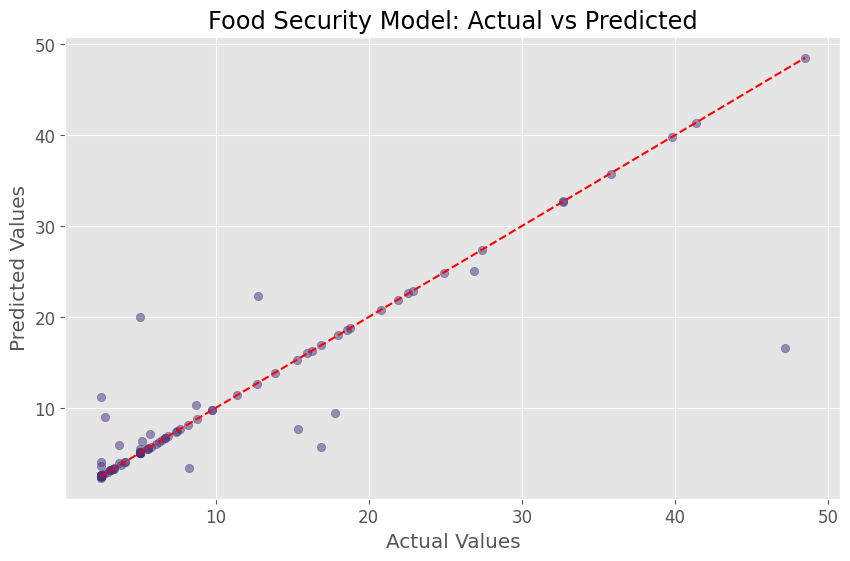

{'RMSE': np.float64(3.8281224258686652), 'MAE': 1.0273562047333844, 'R2': 0.8555056649894076}


In [ ]:
print("=== Food Security Model Evaluation ===")
food_metrics = evaluate_food_security_model(food_model, X_food_test, y_food_test)
print(food_metrics)


=== Demand Forecasting Model Evaluation ===


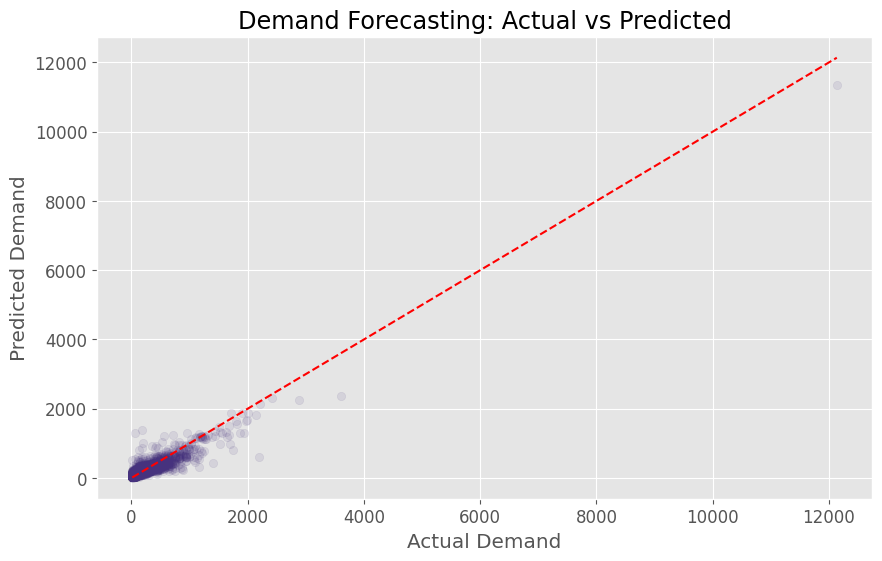

{'RMSE': np.float64(148.82637876272136), 'MAE': 90.55599975585938, 'R2': 0.8705459237098694}


In [ ]:
print("\n=== Demand Forecasting Model Evaluation ===")
demand_metrics = evaluate_demand_model(demand_model, X_demand_test, y_demand_test)
print(demand_metrics)


=== Logistics Efficiency Model Evaluation ===


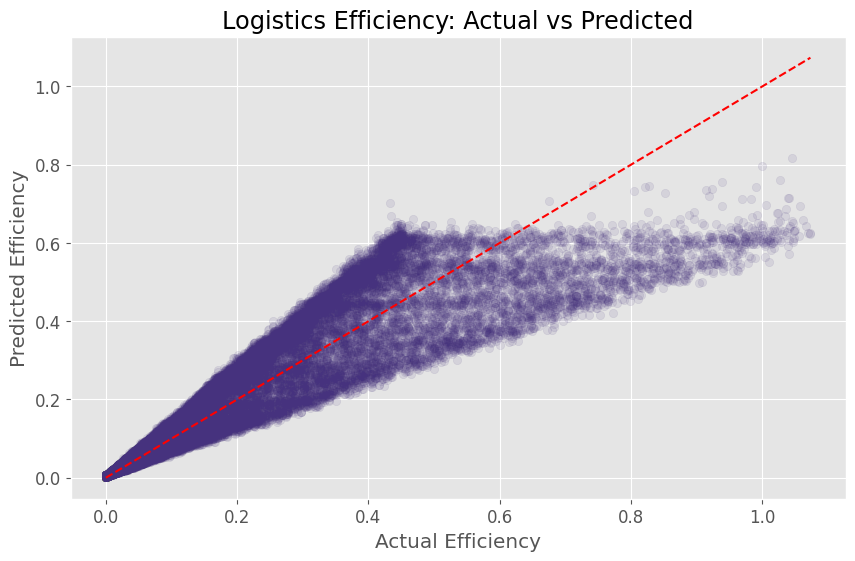

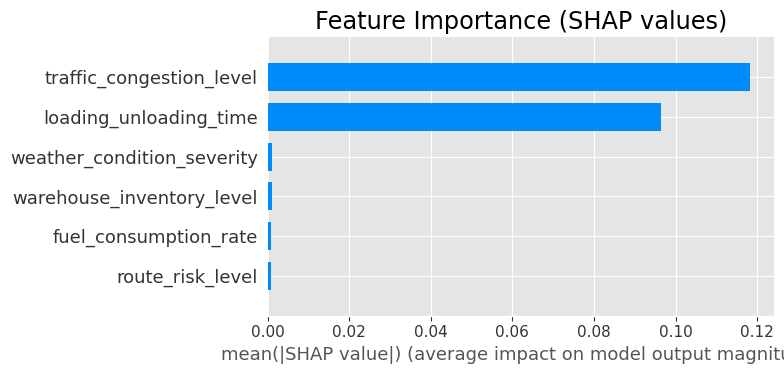

{'RMSE': np.float64(0.0831667323746766), 'MAE': 0.050970338341028605, 'R2': 0.8405028206032591}


In [ ]:
print("\n=== Logistics Efficiency Model Evaluation ===")
log_metrics = evaluate_logistics_model(log_model, X_log_test, y_log_test)
print(log_metrics)


=== Nutrition Quality Model Evaluation ===


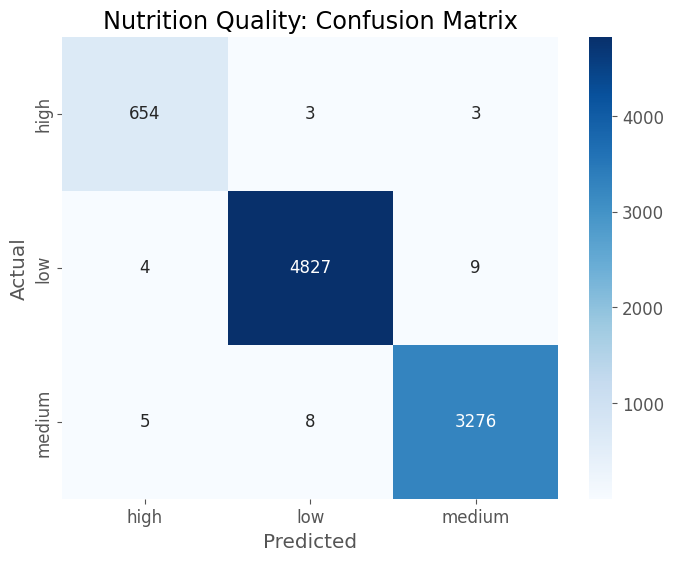

0.9963590852201616
              precision    recall  f1-score   support

        high       0.99      0.99      0.99       660
         low       1.00      1.00      1.00      4840
      medium       1.00      1.00      1.00      3289

    accuracy                           1.00      8789
   macro avg       0.99      0.99      0.99      8789
weighted avg       1.00      1.00      1.00      8789



In [ ]:
print("\n=== Nutrition Quality Model Evaluation ===")
nut_metrics = evaluate_nutrition_model(nut_model, X_nut_test, y_nut_test)
print(nut_metrics['Accuracy'])
print(nut_metrics['Classification Report'])


=== RL Agent Evaluation ===


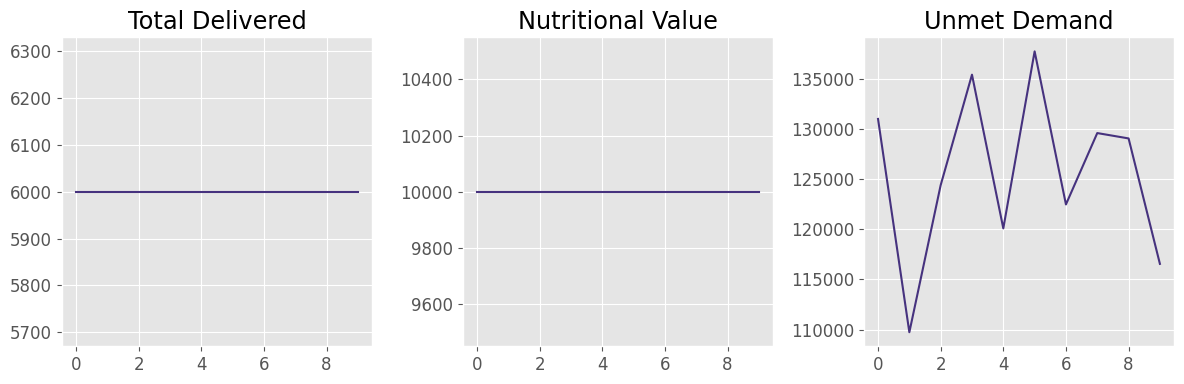

{'Avg Delivered': np.float64(6000.0), 'Avg Nutrition': np.float64(10000.0), 'Avg Unmet Demand': np.float64(125584.23135568718), 'Avg Reward': np.float64(-19.11684627113744)}


In [ ]:
print("\n=== RL Agent Evaluation ===")
env = FoodAllocationEnv(food_demand, nutrition, logistics)
rl_metrics = evaluate_rl_agent(trained_agent, env)
print(rl_metrics)